In [2]:
import matplotlib
import  pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import numpy.ma as ma
%matplotlib inline

In [3]:
df =  pd.read_csv(os.getcwd() +"/data/data.csv",index_col=0)

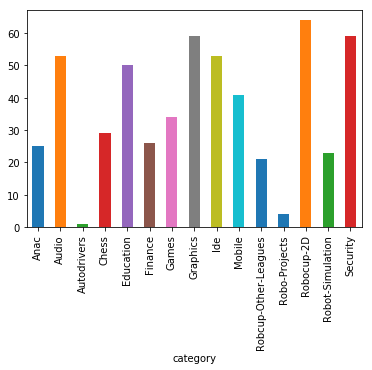

In [4]:
df.groupby('category').count()['type'].plot(kind='bar')

In [5]:
low = .01
high = .9816
quant_df = df['analizo_accm_mean'].quantile([low, high])
quant_df

0.0100        1.111587
0.9816    10441.688296
Name: analizo_accm_mean, dtype: float64

In [6]:
df_reduced =df.loc[df['analizo_accm_mean']<=quant_df[high]].copy()


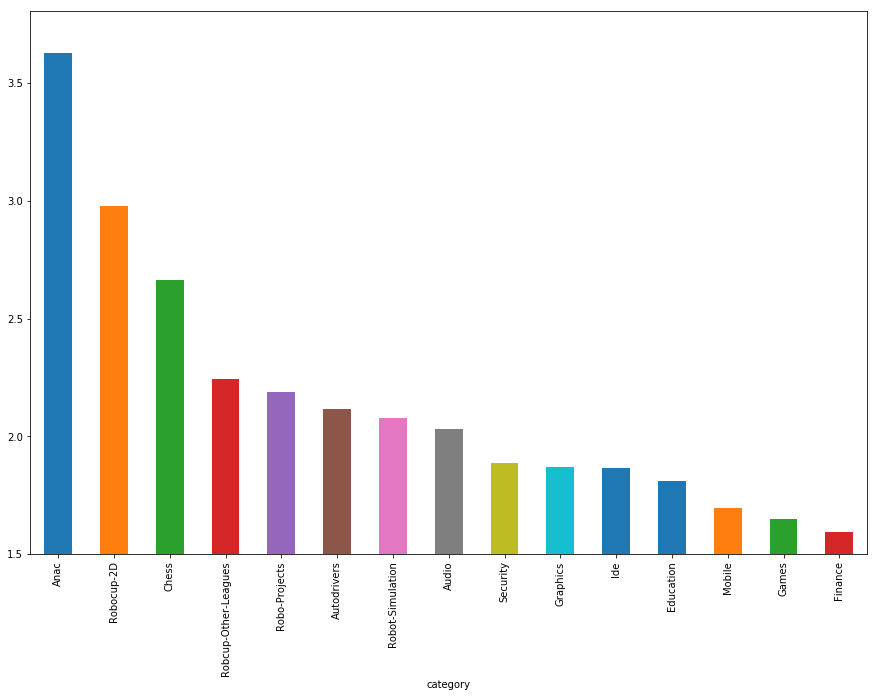

In [26]:

df_reduced.groupby('category').median()['analizo_accm_mean'].sort_values(ascending=False).plot(kind='bar',figsize=(15,10),)
plt.ylim(ymin=1.5)
plt.savefig('fig/accm_dist.eps',dpi=1200,format='eps')

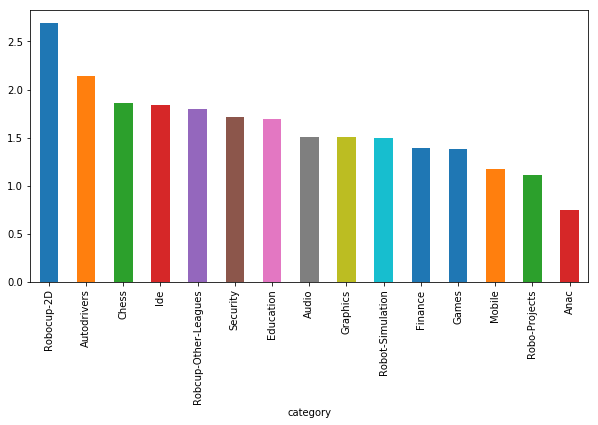

In [8]:
df_reduced.groupby('category').median()['analizo_acc_mean'].sort_values(ascending=False).plot(kind='bar',figsize=(10,5))

In [9]:
from scipy import stats
from operator import itemgetter

In [10]:
diff_vars = []
cat_lst = list(df_reduced[df_reduced['agent_type']=='agent']['category'].unique())
cat_lst.extend(df_reduced[df_reduced['agent_type']=='non-agent']['category'].unique())

In [11]:
variables = list(df_reduced.select_dtypes(include=[np.number]).columns)

In [72]:
diff_vars = {}
rep1= set()
for var in variables:
    ks_stats = []        
    
    for cat in cat_lst:
        rvs2 = df_reduced[(df_reduced['agent_type']=='non-agent')][var]
        rvs1 = df_reduced[df_reduced['category']==cat][var]
        
        p = stats.ks_2samp(rvs1, rvs2)[1]
        if (p<0.005) and (rvs1.mean()>rvs2.mean()):
            ks_stats.append((cat,p))
        if len(ks_stats)>=3:
            
           
            cats , ps = zip(*ks_stats)
            rep1 |= set(cats)
            diff_vars[var[var.find('_')+1:]] = [list(cats) ,sum(ps) / float(len(ps))]
            #sorted (ks_stats,key=itemgetter(1))
    

In [73]:
stat_df = pd.DataFrame.from_dict(diff_vars).transpose()
stat_df.columns = ['Repositories','p_value']
stat_df.p_value = stat_df.p_value.astype(float)
pd.set_option('display.float_format', '{:.2E}'.format)

In [74]:

stat_df.sort_values('p_value',inplace=True)

In [75]:
print(stat_df[0:15].to_latex())

\begin{tabular}{llr}
\toprule
{} &                                 Repositories &  p\_value \\
\midrule
accm\_mean             &                    [Robocup-2D, Chess, Anac] & 1.12E-07 \\
accm\_quantile\_upper   &                    [Robocup-2D, Chess, Anac] & 3.36E-06 \\
accm\_quantile\_median  &                    [Robocup-2D, Chess, Anac] & 2.19E-05 \\
amloc\_quantile\_lower  &                    [Robocup-2D, Chess, Anac] & 4.50E-05 \\
total\_cof             &                    [Robocup-2D, Chess, Anac] & 7.27E-05 \\
amloc\_quantile\_upper  &  [Robocup-2D, Chess, Anac, Robot-Simulation] & 1.80E-04 \\
rfc\_quantile\_upper    &                    [Robocup-2D, Chess, Anac] & 3.20E-04 \\
mmloc\_quantile\_lower  &                    [Robocup-2D, Chess, Anac] & 4.21E-04 \\
amloc\_mean            &  [Robocup-2D, Chess, Anac, Robot-Simulation] & 5.12E-04 \\
rfc\_mean              &                    [Robocup-2D, Chess, Anac] & 6.06E-04 \\
mmloc\_quantile\_median &                    [Robo

In [14]:
diff_v = {k[k.find('_')+1:]: [ 1 if r in v[0] else 0 for r in rep1] +[v[1]] for k,v in diff_vars.iteritems()}
diff_v

{'accm_mean': [0, 1, 0, 1, 0, 1, 1.1167839411003145e-07],
 'accm_quantile_median': [0, 1, 0, 1, 0, 1, 2.1861071229371833e-05],
 'accm_quantile_upper': [0, 1, 0, 1, 0, 1, 3.3595337663259722e-06],
 'accm_standard_deviation': [0, 1, 0, 1, 0, 1, 0.0015626546153637364],
 'amloc_mean': [1, 1, 0, 1, 0, 1, 0.0005119692735373355],
 'amloc_quantile_lower': [0, 1, 0, 1, 0, 1, 4.499753482806932e-05],
 'amloc_quantile_median': [0, 1, 0, 1, 0, 1, 0.0014996305029952581],
 'amloc_quantile_upper': [1, 1, 0, 1, 0, 1, 0.00018038660880013158],
 'anpm_quantile_lower': [0, 0, 1, 1, 0, 1, 0.0010039475677778382],
 'loc_mean': [0, 0, 1, 1, 0, 1, 0.0013702012131811437],
 'loc_quantile_upper': [0, 0, 0, 1, 1, 1, 0.0015043589535732262],
 'mmloc_mean': [1, 0, 0, 1, 0, 1, 0.0014989237487811136],
 'mmloc_quantile_lower': [0, 1, 0, 1, 0, 1, 0.00042058618156029477],
 'mmloc_quantile_median': [0, 1, 0, 1, 0, 1, 0.0006370817414124356],
 'mmloc_quantile_upper': [1, 0, 0, 1, 0, 1, 0.0007447810341281421],
 'nom_mean': [0, 

In [15]:
df =  pd.DataFrame.from_dict(diff_v,orient='index',columns=rep1+['p']).sort_values('p')
df

,Robot-Simulation,Chess,Graphics,Robocup-2D,Audio,Anac,p
accm_mean,0,1,0,1,0,1,1.116784e-07
accm_quantile_upper,0,1,0,1,0,1,3.359534e-06
accm_quantile_median,0,1,0,1,0,1,2.186107e-05
amloc_quantile_lower,0,1,0,1,0,1,4.499753e-05
total_cof,0,1,0,1,0,1,7.272069e-05
amloc_quantile_upper,1,1,0,1,0,1,1.803866e-04
rfc_quantile_upper,0,1,0,1,0,1,3.204294e-04
mmloc_quantile_lower,0,1,0,1,0,1,4.205862e-04
amloc_mean,1,1,0,1,0,1,5.119693e-04
rfc_mean,0,1,0,1,0,1,6.062511e-04


In [28]:
print(df[0:10].to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  Robot-Simulation &  Chess &  Graphics &  Robocup-2D &  Audio &  Anac &             p \\
\midrule
accm\_mean            &                 0 &      1 &         0 &           1 &      0 &     1 &  1.116784e-07 \\
accm\_quantile\_upper  &                 0 &      1 &         0 &           1 &      0 &     1 &  3.359534e-06 \\
accm\_quantile\_median &                 0 &      1 &         0 &           1 &      0 &     1 &  2.186107e-05 \\
amloc\_quantile\_lower &                 0 &      1 &         0 &           1 &      0 &     1 &  4.499753e-05 \\
total\_cof            &                 0 &      1 &         0 &           1 &      0 &     1 &  7.272069e-05 \\
amloc\_quantile\_upper &                 1 &      1 &         0 &           1 &      0 &     1 &  1.803866e-04 \\
rfc\_quantile\_upper   &                 0 &      1 &         0 &           1 &      0 &     1 &  3.204294e-04 \\
mmloc\_quantile\_lower &                 0 &      1 &         0 & 

In [17]:
df_reduced['agent_cat'] = pd.Categorical(df_reduced['agent_type'],['agnet','Robot','non-agent'])
df_reduced.sort_values('agent_cat',inplace=True)

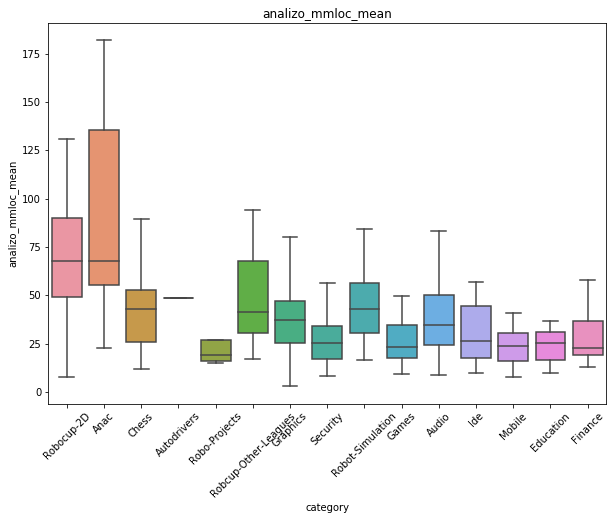

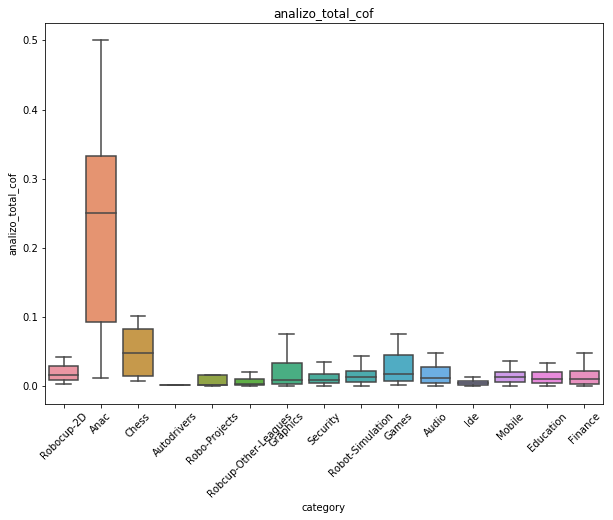

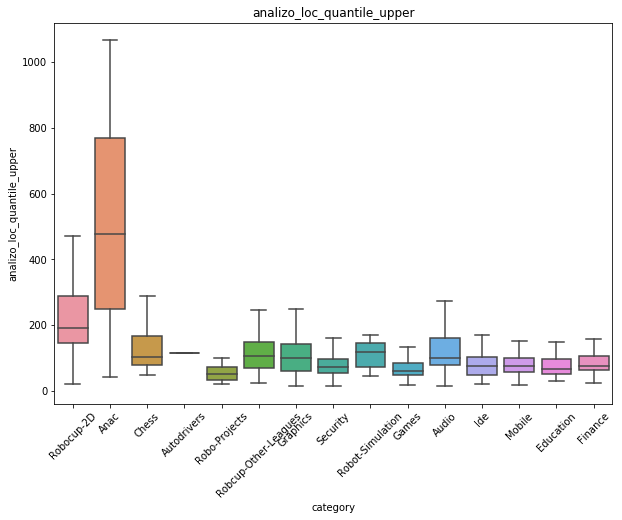

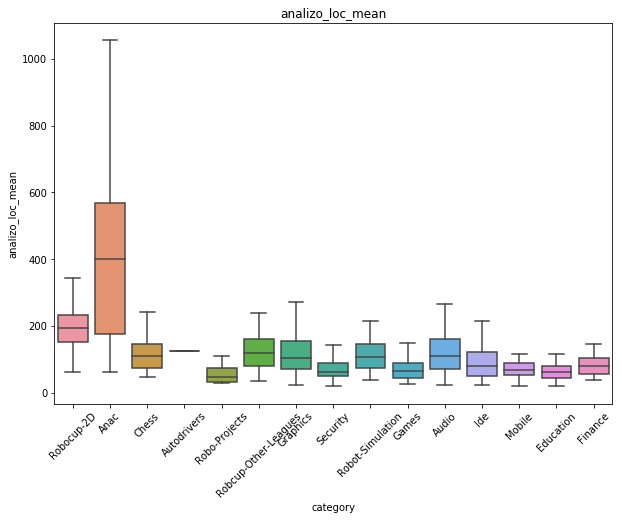

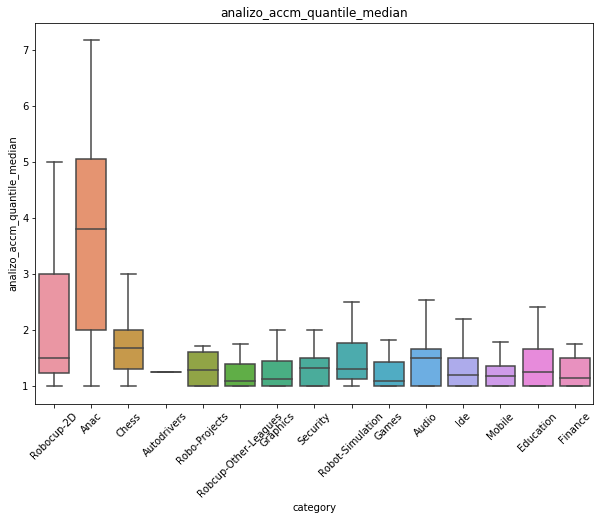

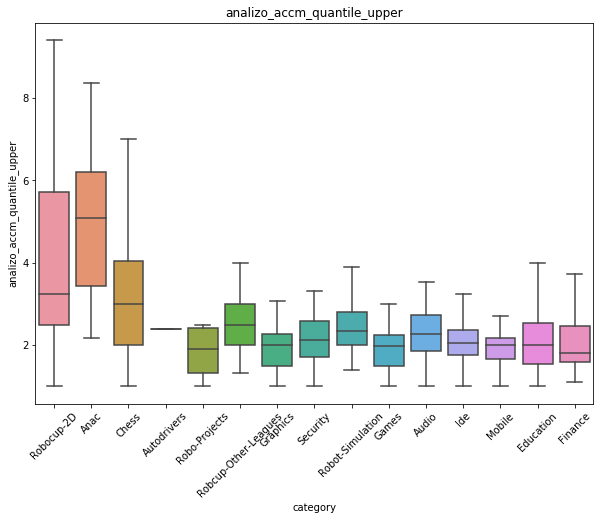

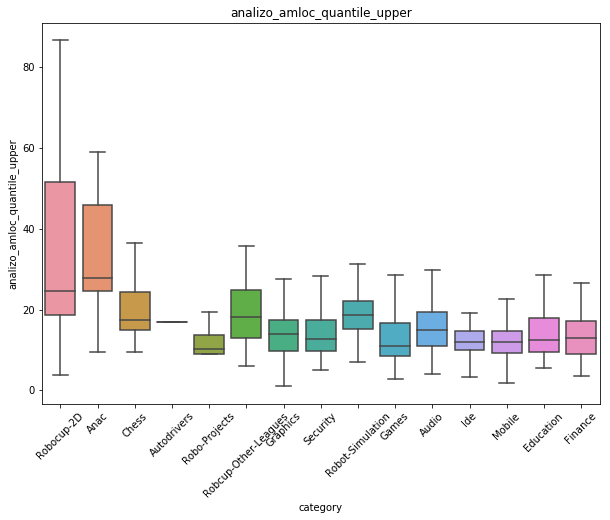

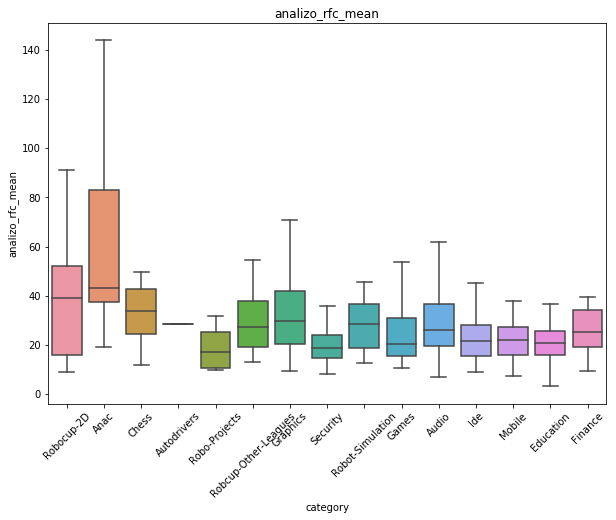

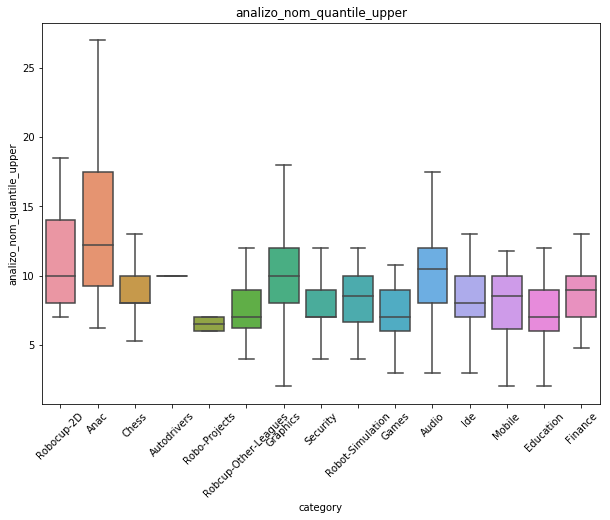

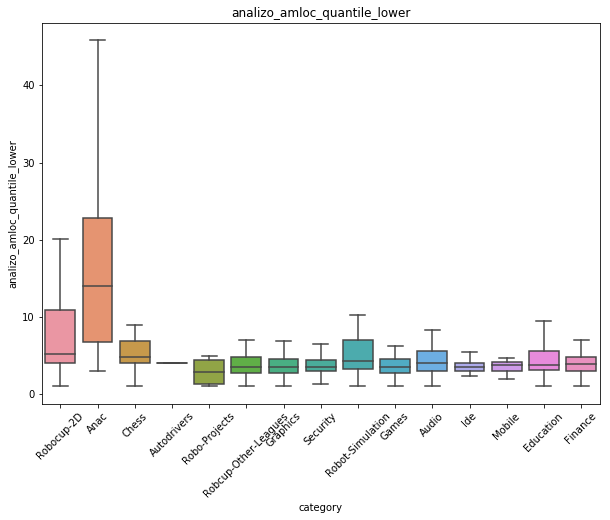

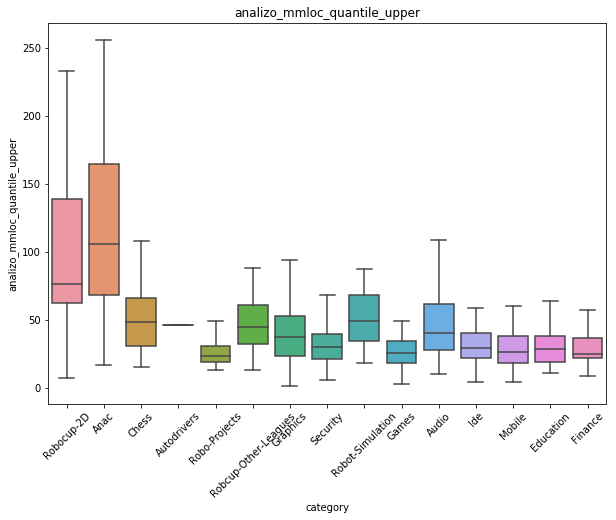

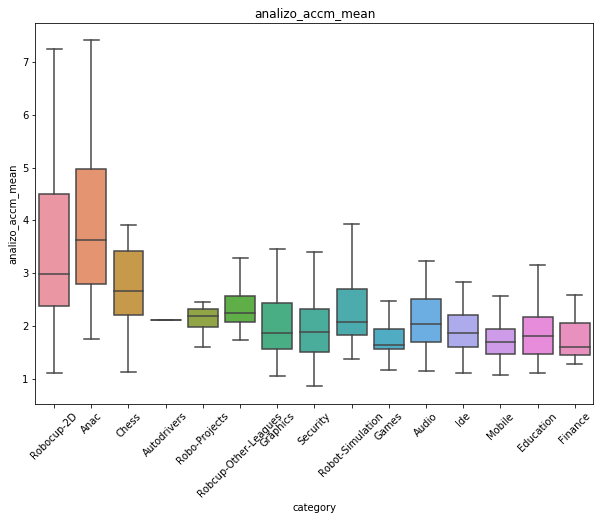

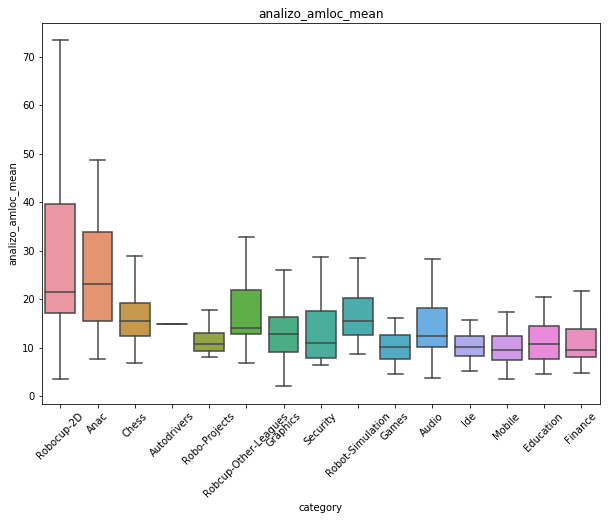

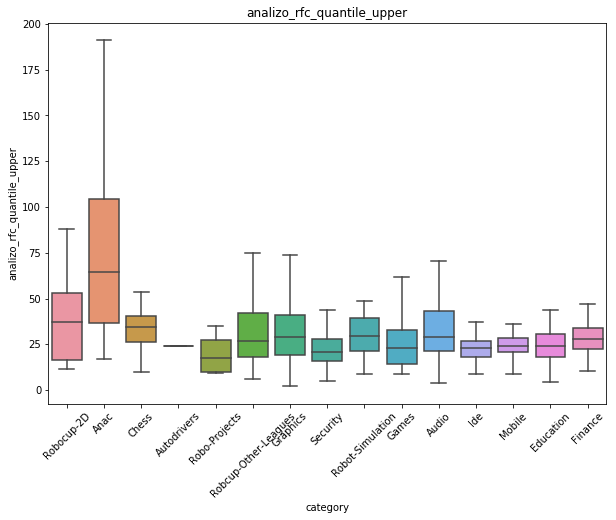

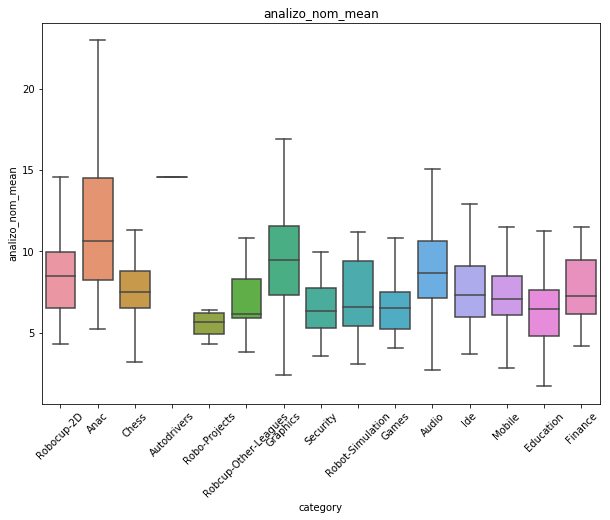

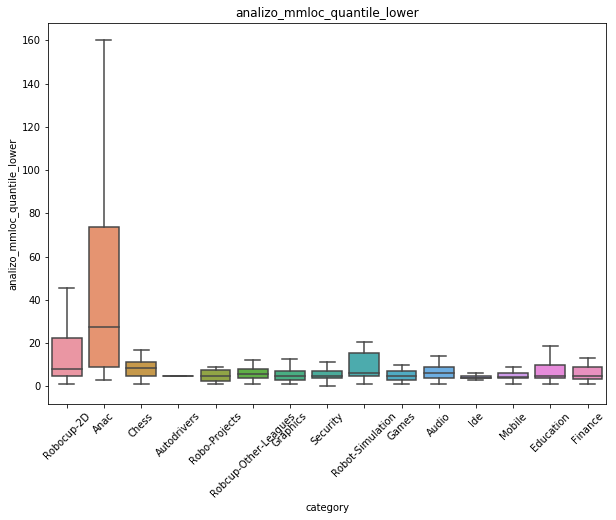

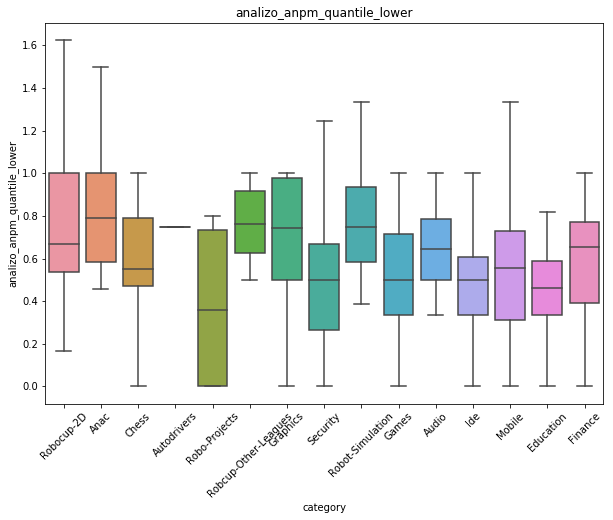

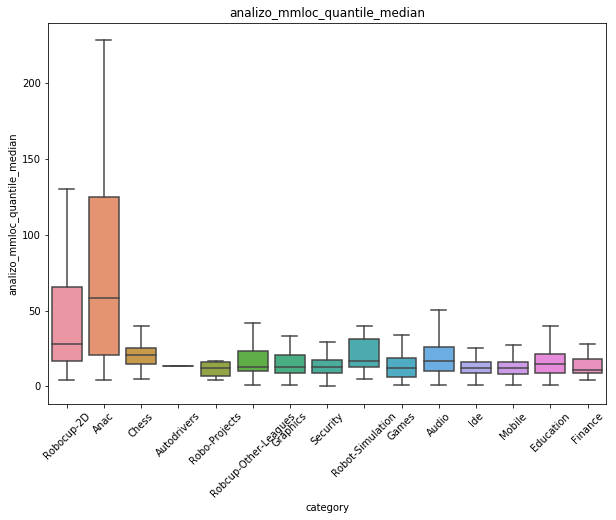

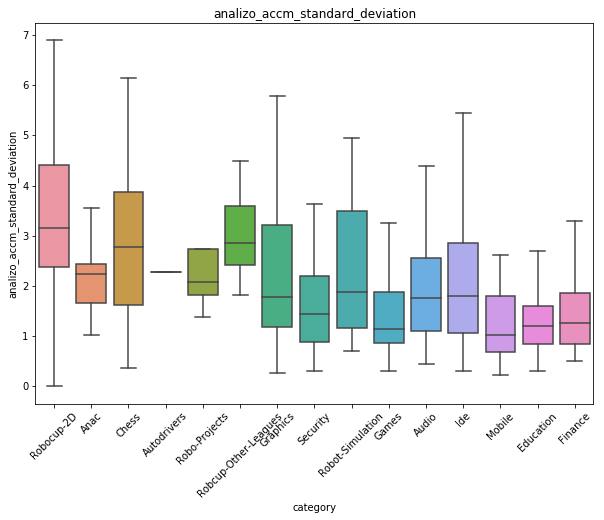

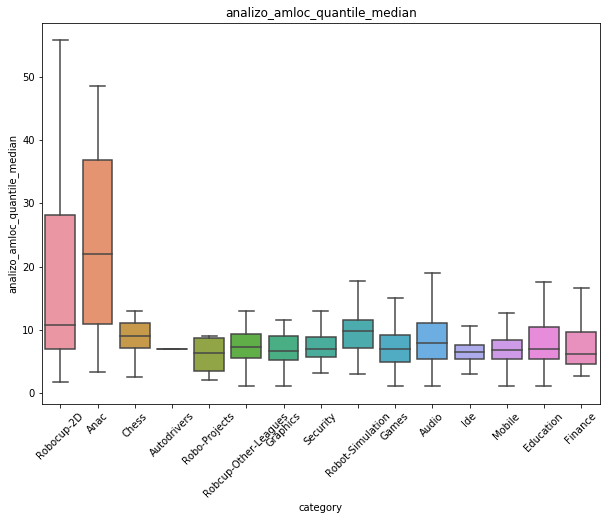

In [18]:
for var in diff_vars:
    
    fix,ax = plt.subplots(figsize=(10,7),)
    sns.boxplot(x='category',y=var,data=df_reduced,showfliers=False).set_title(var)
    #g = sns.swarmplot(x='category',y=var,data=df_reduced,color='black')
    plt.setp(ax.get_xticklabels(), rotation=45)
#     for item in g.get_xticklabels():
#          item.set_rotation(90)
            

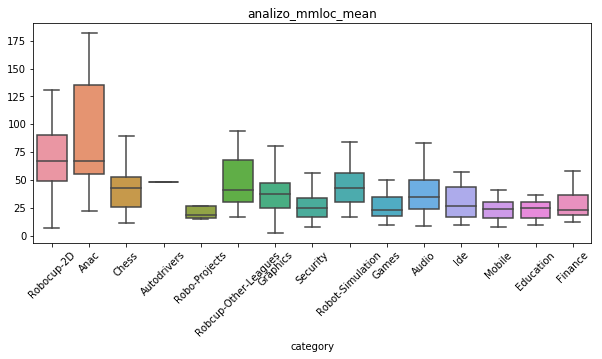

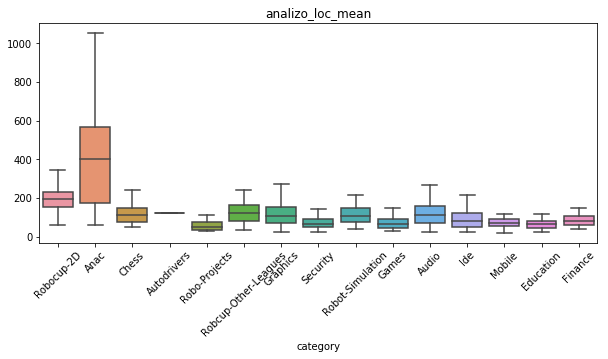

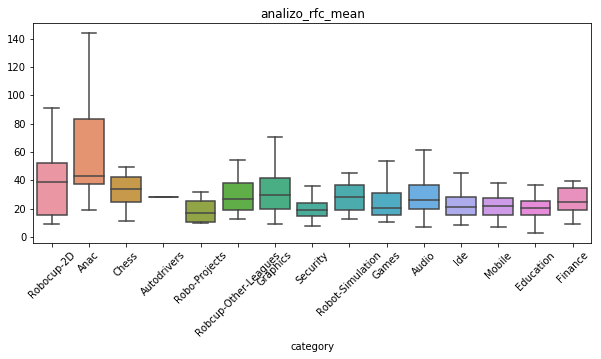

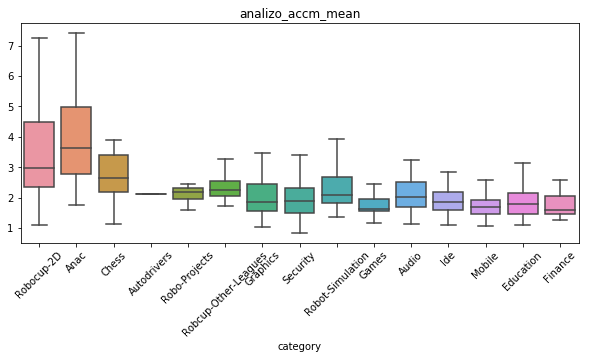

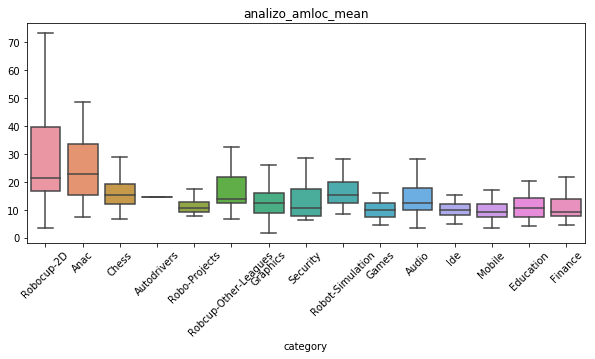

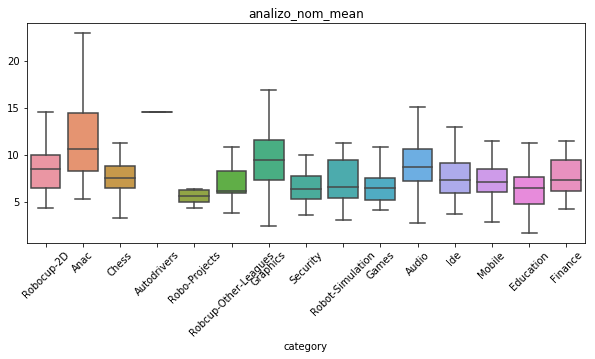

In [19]:
for var in [c for c in diff_vars if 'mean'  in c]:
    
    fix,ax = plt.subplots(figsize=(10,5),)
    sns.boxplot(ax=ax , x='category',y=var,data=df_reduced,showfliers=False).set_title(var)
    plt.gcf().subplots_adjust(bottom=0.27)
    #g = sns.swarmplot(x='category',y=var,data=df_reduced,color='black')
    plt.setp(ax.get_xticklabels(), rotation=45)
    
    x_axis = ax.axes.get_yaxis()
    x_axis.set_label_text('foo')
    x_label = x_axis.get_label()
    ##print isinstance(x_label, matplotlib.artist.Artist)
    x_label.set_visible(False)
    plt.savefig('fig/'+var+"_output.eps",dpi=1200,format='eps')


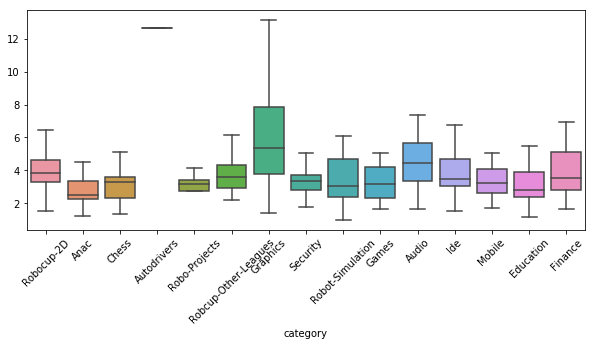

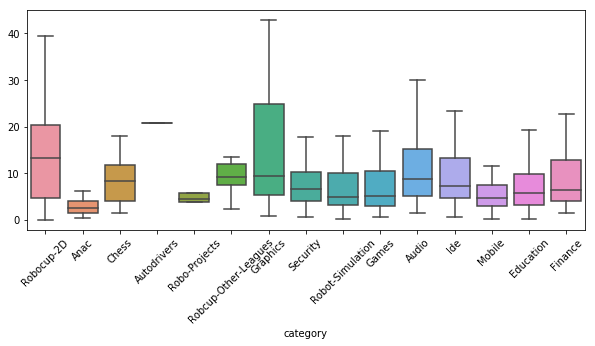

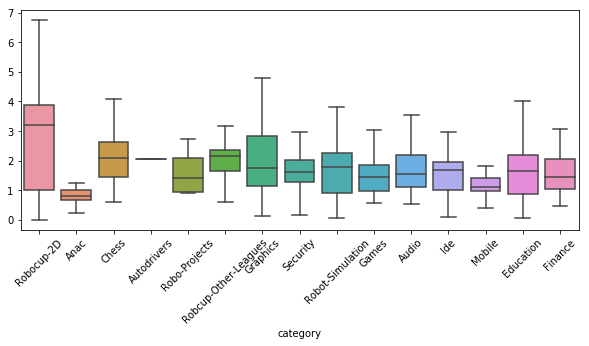

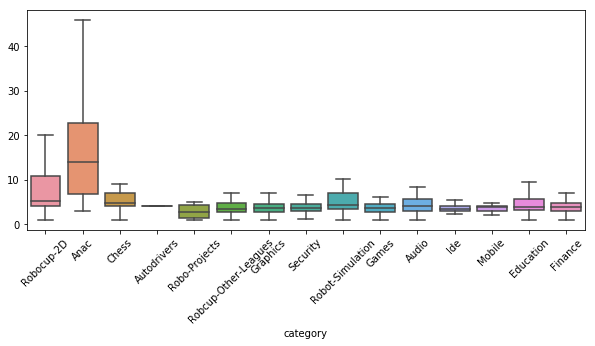

In [21]:
features = ["analizo_lcom4_mean",'analizo_sc_mean','analizo_cbo_mean','analizo_amloc_quantile_lower']


for var in features:
    
    fix,ax = plt.subplots(figsize=(10,5),)
    sns.boxplot(ax=ax , x='category',y=var,data=df_reduced,showfliers=False)
    plt.gcf().subplots_adjust(bottom=0.27)
    #g = sns.swarmplot(x='category',y=var,data=df_reduced,color='black')
    plt.setp(ax.get_xticklabels(), rotation=45)
    
    x_axis = ax.axes.get_yaxis()
    x_axis.set_label_text('foo')
    x_label = x_axis.get_label()
    ##print isinstance(x_label, matplotlib.artist.Artist)
    x_label.set_visible(False)
    plt.savefig('fig/'+var+"_output.eps",dpi=1200,format='eps')



In [ ]:
df2 =  pd.read_csv(os.getcwd() +"/data/robo-sim-data.csv",index_col=0)

In [ ]:
df2 = df2[~df2['McCabes_cyclomatic_complexity'].isnull()].copy()

In [30]:
df2['cc_per_line_of_code'] = df2['McCabes_cyclomatic_complexity'] / df2['analizo_total_loc']

KeyError: 'McCabes_cyclomatic_complexity'

In [31]:
df2['McCabes_cyclomatic_complexity'].hist(range=(0,2500))

KeyError: 'McCabes_cyclomatic_complexity'

In [32]:
df2.plot.scatter(x='analizo_accm_mean',y='cc_per_line_of_code' )
plt.ylim(0,1)

KeyError: 'cc_per_line_of_code'